In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import GroupKFold
import pickle 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#读取32个通道的EEG数据，每个通道包含32×40=1280个信号样本（人次×每人次40实验）
#每个样本向量大小为8064点（63s*128Hz）
for eeg_CH in range(1,33,1):
    file_path = "./dump_file/CH{}_df_EEG_x".format(eeg_CH)
    locals()['CH{}_df_EEG_x'.format(eeg_CH)] = pickle.load(open(file_path,"rb"))

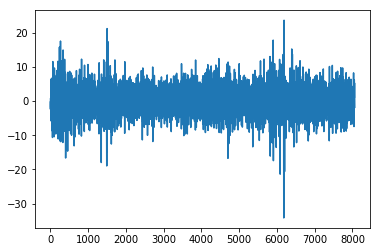

In [3]:
plt.plot(CH10_df_EEG_x.iloc[0,:])

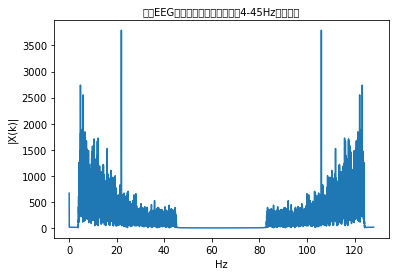

In [10]:
#EEG DFT(FFT)频域数据
def eegFFT(df_data):
    eegfft_df = pd.DataFrame()
    for i in df_data.index.tolist():
        temp_eegfft = pd.DataFrame(np.fft.fft(df_data.loc[i,:].values)).T
        temp_eegfft.index = [i]
        eegfft_df = eegfft_df.append(temp_eegfft)
    return eegfft_df

df = eegFFT(CH1_df_EEG_x)
fft_abs = abs(df.iloc[0,:])
X = [(n-1)*128/8064 for n in range(1,8065,1) ]
plt.plot(X,fft_abs)
plt.xlabel("Hz")
plt.ylabel("|X(k)|")
plt.title(u'某个EEG信号的频谱，从图看已经4-45Hz滤波之后',fontproperties='SimHei')
plt.show()

In [12]:
X[60]

0.9523809523809523